In [27]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [28]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS =3
EPOCHS = 11

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# prompt: how to upload from my laptop in colab and save in files section

from google.colab import files

# Upload the file from your laptop
uploaded = files.upload()

# Save the uploaded file to the files section in Colab
for fn in uploaded.keys():
  with open(fn, 'wb') as f:
    f.write(uploaded[fn])


In [31]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Tomato_dataset',shuffle = True ,
                                                              image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 2994 files belonging to 3 classes.


In [32]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [33]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(32, 256, 256, 3)
[2 2 0 1 2 0 0 1 2 0 0 1 0 1 2 1 2 2 0 2 1 2 2 2 1 1 2 2 0 1 0 0]


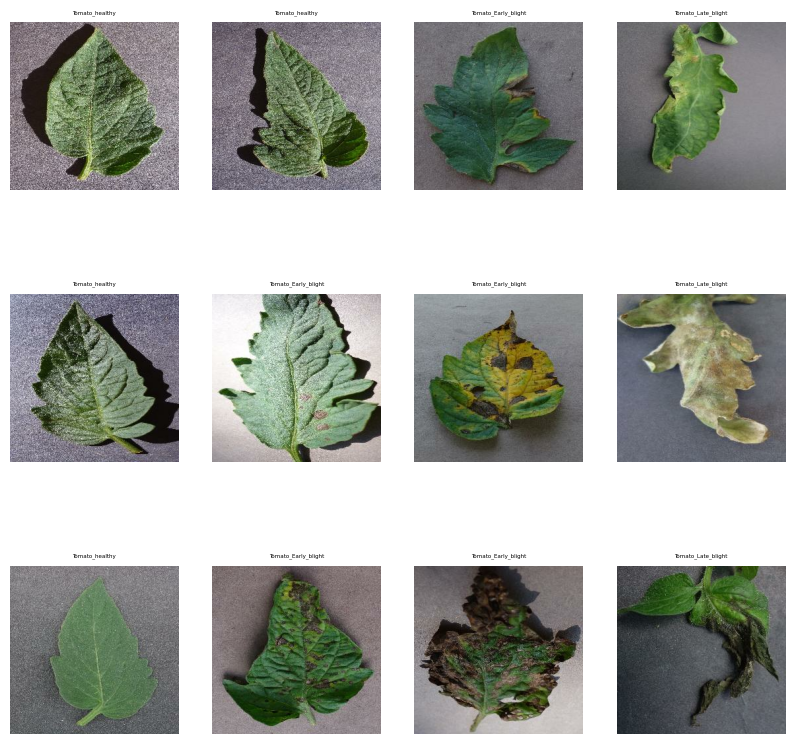

In [34]:


plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]],size=4)
        plt.axis("off")
    plt.show()

In [35]:
''' 80% ==> Training
20% test:
    10% ==> Validation
    10% ==> Test'''

train_size = 0.8
len(dataset)
len(dataset)*train_size

75.2

In [36]:
train_ds = dataset.take(75)
len(train_ds)

75

In [37]:
test_ds = dataset.skip(75)

In [38]:
len(test_ds)

19

In [39]:
val_size = 0.1
len(dataset)*val_size

9.4

In [40]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [41]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+test_split+val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size ,seed = 12)
    train_size = int(train_split*ds_size)
    val_size = int(val_size*ds_size)

    train_ds = ds.take(train_size)
    val_size = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train.skip).skip(val_size)

    return train_ds,val_ds,test_ds

In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
for image_batch , label_batch in dataset.take(1):
  # IN Image Processing image Normalization is important for the better interpretation for the user anf the computer Both\.\

    print(image_batch[0].numpy()/255)
'''  As you can see the whole data falls into the range of 0 & 1 , hence this numerical representation of the number is normalized. '''

[[[0.83137256 0.8039216  0.83137256]
  [0.8666667  0.8392157  0.8666667 ]
  [0.90588236 0.8784314  0.90588236]
  ...
  [0.5176471  0.4862745  0.5294118 ]
  [0.8156863  0.78431374 0.827451  ]
  [0.8901961  0.85882354 0.9019608 ]]

 [[0.84313726 0.8156863  0.84313726]
  [0.8666667  0.8392157  0.8666667 ]
  [0.89411765 0.8666667  0.89411765]
  ...
  [0.7176471  0.6862745  0.7294118 ]
  [0.75686276 0.7254902  0.76862746]
  [0.69411767 0.6627451  0.7058824 ]]

 [[0.8745098  0.84705883 0.8745098 ]
  [0.88235295 0.85490197 0.88235295]
  [0.89411765 0.8666667  0.89411765]
  ...
  [0.75686276 0.7254902  0.76862746]
  [0.6431373  0.6117647  0.654902  ]
  [0.6509804  0.61960787 0.6627451 ]]

 ...

 [[0.68235296 0.6313726  0.65882355]
  [0.65882355 0.60784316 0.63529414]
  [0.6509804  0.6        0.627451  ]
  ...
  [0.47843137 0.42745098 0.4627451 ]
  [0.5176471  0.46666667 0.5019608 ]
  [0.49803922 0.44705883 0.48235294]]

 [[0.63529414 0.58431375 0.6117647 ]
  [0.6392157  0.5882353  0.6156863 ]


'  As you can see the whole data falls into the range of 0 & 1 , hence this numerical representation of the number is normalized. '

In [44]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [45]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [46]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
            resize_and_rescale,
            data_augmentation,
            layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape = input_shape),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Flatten(),
            layers.Dense(64,activation='relu'),
            layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                 

In [48]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [49]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose =1,
    epochs = EPOCHS
)

Epoch 1/11
75/75 [==============================] - 324s 3s/step - loss: 1.0489 - accuracy: 0.4317 - val_loss: 0.9305 - val_accuracy: 0.5486
Epoch 2/11
75/75 [==============================] - 237s 3s/step - loss: 0.7934 - accuracy: 0.6354 - val_loss: 0.7612 - val_accuracy: 0.6632
Epoch 3/11
75/75 [==============================] - 242s 3s/step - loss: 0.6346 - accuracy: 0.7354 - val_loss: 0.6620 - val_accuracy: 0.7396
Epoch 4/11
75/75 [==============================] - 238s 3s/step - loss: 0.5638 - accuracy: 0.7775 - val_loss: 0.5126 - val_accuracy: 0.7812
Epoch 5/11
75/75 [==============================] - 248s 3s/step - loss: 0.4225 - accuracy: 0.8246 - val_loss: 0.5251 - val_accuracy: 0.7812
Epoch 6/11
75/75 [==============================] - 237s 3s/step - loss: 0.4081 - accuracy: 0.8238 - val_loss: 0.9007 - val_accuracy: 0.6875
Epoch 7/11
75/75 [==============================] - 237s 3s/step - loss: 0.3691 - accuracy: 0.8392 - val_loss: 0.4676 - val_accuracy: 0.8229
Epoch 8/11
75

In [50]:
scores = model.evaluate(test_ds)

19/19 [==============================] - 27s 818ms/step - loss: 0.4360 - accuracy: 0.8451


In [51]:
'''
    New Chapter In TF
       [ HISTORY ]
 this is callback history , where each and every steps and details are noted and saved as the history ,
 INSHORT - BlackBox of ur model
 '''

history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
history.params

{'verbose': 1, 'epochs': 11, 'steps': 75}

In [53]:
history.history['loss']

[1.0488836765289307,
 0.7933716177940369,
 0.634578287601471,
 0.5638445615768433,
 0.4224904477596283,
 0.4081377685070038,
 0.3690689504146576,
 0.3393439054489136,
 0.30656737089157104,
 0.29698219895362854,
 0.2590273916721344]

In [54]:
history.history['accuracy']

[0.43166667222976685,
 0.6354166865348816,
 0.7354166507720947,
 0.7774999737739563,
 0.8245833516120911,
 0.8237500190734863,
 0.8391666412353516,
 0.8554166555404663,
 0.8712499737739563,
 0.8787500262260437,
 0.8949999809265137]

In [55]:
history.history['val_accuracy']

[0.5486111044883728,
 0.6631944179534912,
 0.7395833134651184,
 0.78125,
 0.78125,
 0.6875,
 0.8229166865348816,
 0.8055555820465088,
 0.8541666865348816,
 0.8229166865348816,
 0.8472222089767456]

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

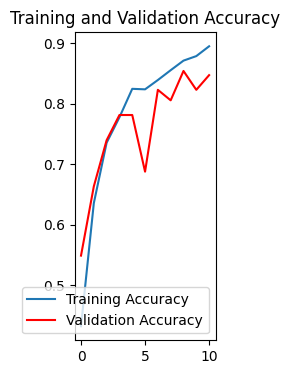

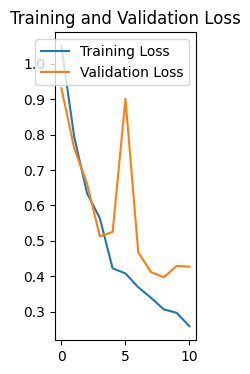

In [57]:
plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy',color='red')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(4,4))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc ='upper right')
plt.title('Training and Validation Loss')
plt.show()

First Image to predict
Label:  1
1/1 [==============================] - 2s 2s/step
[0.03202749 0.7263586  0.24161392]
['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']




' In this Image you can see that the prediction is done in the form of Probablities ratios on the given 3 classes , so\n    every test picture will be comapred to the all the classes given in the model & the correlation btwn pictures will be listed above that\n    the class with higher probability will be our desired result '

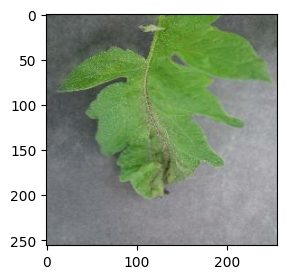

In [58]:
''' Here we gonna predict some random pictures from the dataset , and test the model's accuracy '''

for image_batch,labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")

    plt.figure(figsize=(3,3))
    print("First Image to predict")
    plt.imshow(first_image)
    print("Label: ",labels_batch[0].numpy())

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print(class_names)

    print("\n")
''' In this Image you can see that the prediction is done in the form of Probablities ratios on the given 3 classes , so
    every test picture will be comapred to the all the classes given in the model & the correlation btwn pictures will be listed above that
    the class with higher probability will be our desired result '''


First Image to predict
 Actual Label:  1
1/1 [==============================] - 1s 1s/step
Predicted label:  1
['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']


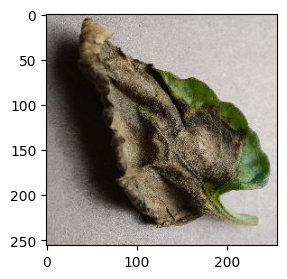

In [59]:
''' Followed by the above code , we will be simplifying the Prediction method :
    - by removing the probabilities of the other classes with help of numpy Argmax function.
    - by adding labels to the result.
    -


'''

      # 1. by removing the probabilities of the other classes with help of numpy Argmax function.
import numpy as np
for image_batch,labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")

    plt.figure(figsize=(3,3))
    print("First Image to predict")
    plt.imshow(first_image)
    print(" Actual Label: ",labels_batch[0].numpy())

    batch_prediction = model.predict(image_batch)
    predict = np.argmax(batch_prediction[0])
    print("Predicted label: ",predict)
   # print(np.argmax(batch_prediction[0]))
    print(class_names)





First Image to predict
 Actual Label:  Tomato_Late_blight
1/1 [==============================] - 1s 862ms/step
Predicted label:  Tomato_Late_blight
1
['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']


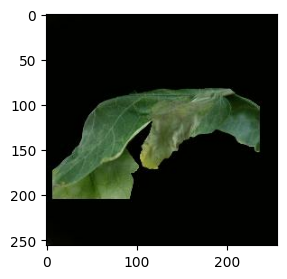

In [85]:
                            #2 by adding labels to the result.
for image_batch,labels_batch in test_ds.take(1):
    first_image = image_batch[1].numpy().astype("uint8")

    plt.figure(figsize=(3,3))
    print("First Image to predict")
    plt.imshow(first_image)
    # Below code we adding a class_names variable
    print(" Actual Label: ",class_names[labels_batch[0].numpy()])
    # print(first_image)
    batch_prediction = model.predict(image_batch)
    predict = class_names[np.argmax(batch_prediction[0])]
    print("Predicted label: ",predict)
    print(np.argmax(batch_prediction[0]))
    print(class_names)
    # print(batch_prediction)


In [64]:
model.save("your_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# prompt: run streamlit app code

! pip install streamlit



In [68]:
!wget -q -O - ipv4.icanhazip.com

34.80.88.63


In [86]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.80.88.63:8501

npx: installed 22 in 3.602s
your url is: https://twenty-shrimps-read.loca.lt
2024-05-08 18:03:56.375880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 18:03:56.375940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 18:03:56.377483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 18:03:57.769266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-08 18:04:12.199 U